### Importing the libraries

In [7]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
!pip install kneed
from kneed import KneeLocator
import pandas as pd
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")


### Creating and importing datasets to be used

##### Dataset 1: High Standard Deviation, Should Be Harder to Cluster

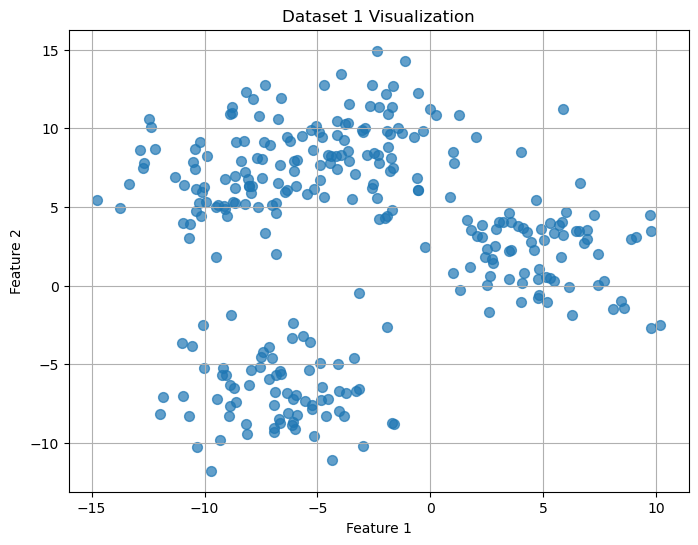

In [8]:
# Set random seed
np.random.seed(42)

# Creating the dataset
data1, _ = make_blobs(n_samples=300, n_features=2, centers=4, cluster_std=2.4, random_state=42)

# Plotting the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data1[:, 0], data1[:, 1], marker='o', s=50, alpha=0.7)
plt.title('Dataset 1 Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

##### Dataset 2: Low Standard Deviation, Easily Seen Clusters, Should Be Easier 

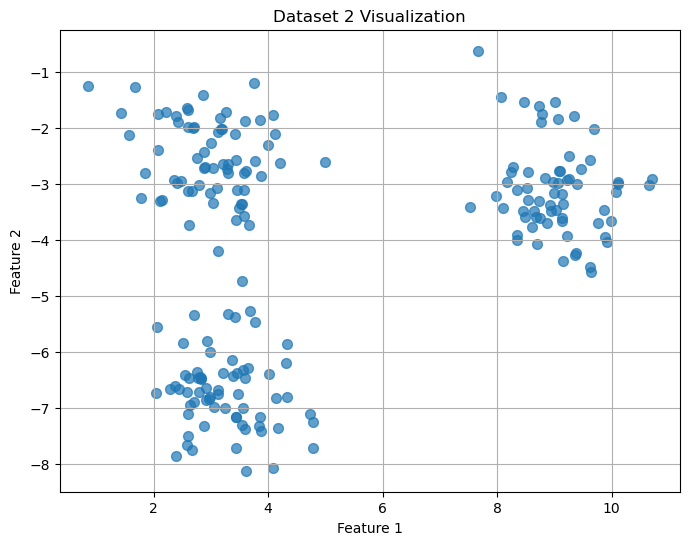

In [28]:
# Set random seed
np.random.seed(30)

# Creating the dataset
data2, _ = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=30)

# Plotting the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data2[:, 0], data2[:, 1], marker='o', s=50, alpha=0.7)
plt.title('Dataset 2 Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

##### Dataset 3: Should Be Tough Added Less Spherical Clusters with Moons and More Noise

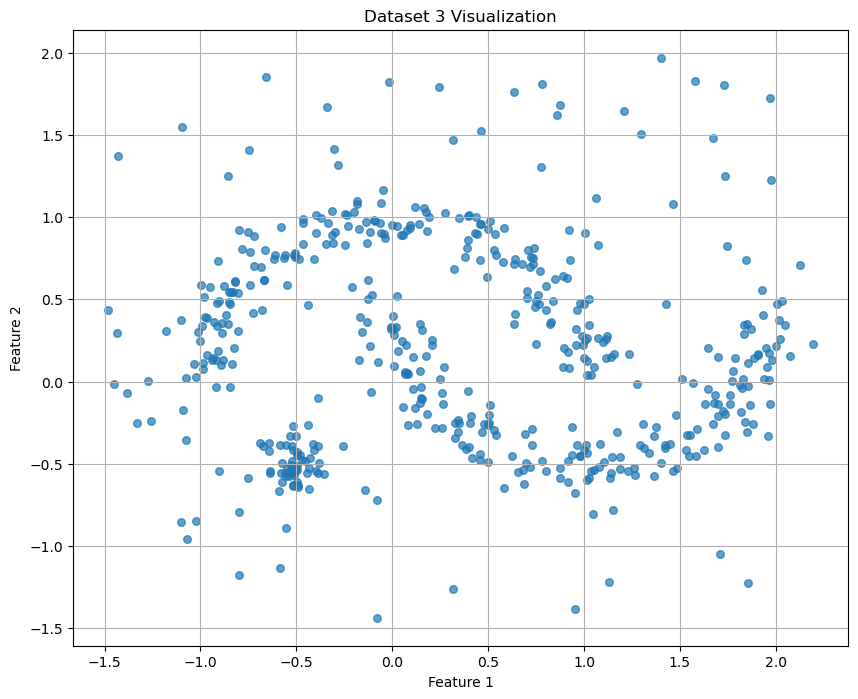

In [29]:
np.random.seed(214)
X_moons, _ = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, _ = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

data3 = np.vstack([X_moons, X_blobs, X_noise])

# Plotting the dataset
plt.figure(figsize=(10, 8))
plt.scatter(data3[:, 0], data3[:, 1], marker='o', s=30, alpha=0.7)
plt.title('Dataset 3 Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

##### Dataset 4: Real World Dataset of Wine, Many Features

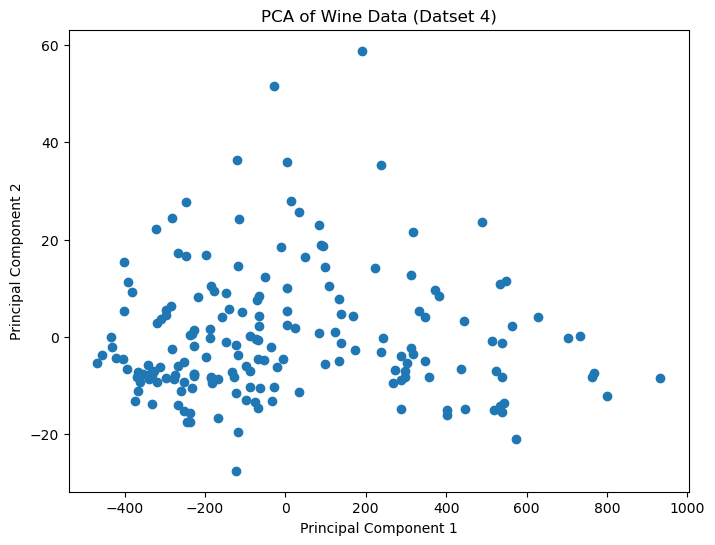

In [30]:
wine_data = pd.read_csv("C:\\Users\\Jordy\\Downloads\\wine-clustering.csv")

pca = PCA(n_components=2)
wine_data_transformed = pca.fit_transform(wine_data)

plt.figure(figsize=(8, 6))
plt.scatter(wine_data_transformed[:, 0], wine_data_transformed[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wine Data (Datset 4)')
plt.show()

### Step 1: Using K-Means to find optimal K

In [12]:
def find_optimal_clusters_silhouette(data, max_k=10):
    best_score = -1
    best_k = 2
    best_model = None

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k).fit(data)
        score = silhouette_score(data, kmeans.labels_)

        if score > best_score:
            best_score = score
            best_k = k
            best_model = kmeans

    return best_k, best_model

In [13]:
def calculate_average_cluster_size(kmeans_model):
    cluster_sizes = np.bincount(kmeans_model.labels_)
    average_size = np.mean(cluster_sizes)
    return int(average_size)

### Step 2: Using nearest neighbor, K, and elbow method to find optimal EPS

In [14]:
def kth_nearest_neighbor_distances(data, k):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(data)
    distances, _ = nn.kneighbors(data)
    return distances[:, k-1]

def find_elbow_point(distances):
    distances_sorted = np.sort(distances)
    knee_locator = KneeLocator(range(len(distances_sorted)), distances_sorted, curve='convex', direction='increasing')
    return distances_sorted[knee_locator.knee]

### Step 3: Running DBSCAN with determined optimal K and EPS

In [24]:
def ensemble_clustering(data, max_k=10):
    # Step 1: Find optimal k for K-means and retain the model
    optimal_k, kmeans_model = find_optimal_clusters_silhouette(data, max_k)

    # average cluster size
    average_cluster_size = calculate_average_cluster_size(kmeans_model)

    # Step 2: k-NN distances and find elbow point for eps
    knn_distances = kth_nearest_neighbor_distances(data, optimal_k)
    eps = find_elbow_point(knn_distances)

    # MinPts Average
    minPts = int(0.15 * average_cluster_size)

     # Step 3: Run DBSCAN with estimated minPts and eps
    dbscan = DBSCAN(eps=eps, min_samples=minPts).fit(data)

    
    return dbscan, eps, minPts, dbscan.labels_

### First Dataset Run

In [25]:
# Run on data
dbscan_model, eps, minPts, cluster_labels = ensemble_clustering(data1, max_k=10)

# Filtering out noise points
filtered_labels = cluster_labels[cluster_labels != -1]
filtered_data = data1[cluster_labels != -1]  

# Calculating silhouette score
if len(set(filtered_labels)) > 1 and len(set(filtered_labels)) < len(filtered_data):
    score = silhouette_score(filtered_data, filtered_labels)
    print("Silhouette Score: ", score)
else:
    print("all points are noise.")

# Printing estimated DBSCAN parameters and number of clusters
print(f"Estimated eps: {eps}")
print(f"Estimated minPts: {minPts}")
print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")


Silhouette Score:  0.662643431814777
Estimated eps: 1.9495688185638886
Estimated minPts: 15
Number of clusters found: 3


#### Visualizations(data1)

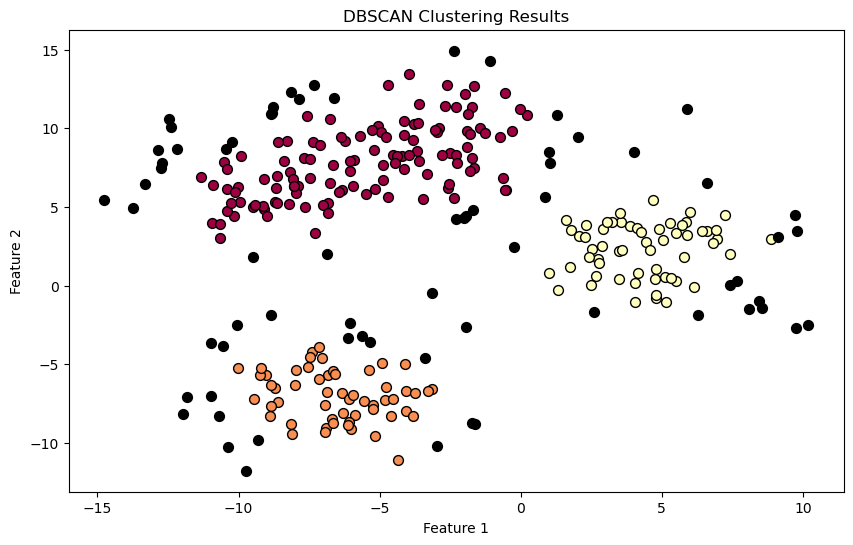

In [26]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(cluster_labels)

# Plottting each cluster
for label in unique_labels:
    if label == -1:
        col = 'k'
        markersize = 6
    else:
        col = plt.cm.Spectral(float(label) / len(unique_labels))
        markersize = 12

    # Plot data points that are part of the cluster (label)
    plt.scatter(data1[cluster_labels == label, 0], data1[cluster_labels == label, 1], c=[col], edgecolor='k', s=50)

plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### Second Dataset Run

In [31]:
# Running the clustering model on data2
dbscan_model, eps, minPts, cluster_labels = ensemble_clustering(data2, max_k=10)

# Filtering out noise points
filtered_labels = cluster_labels[cluster_labels != -1]
filtered_data = data2[cluster_labels != -1]  

# Calculate silhouette score
if len(set(filtered_labels)) > 1 and len(set(filtered_labels)) < len(filtered_data):
    score = silhouette_score(filtered_data, filtered_labels)
    print("Silhouette Score: ", score)
else:
    print("all points are noise.")

# Print DBSCAN estimated parameters and number of clusters
print(f"Estimated eps: {eps}")
print(f"Estimated minPts: {minPts}")
print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")


Silhouette Score:  0.8059816340842961
Estimated eps: 0.49762104714342126
Estimated minPts: 9
Number of clusters found: 3


##### Visualization (Dataset 2)

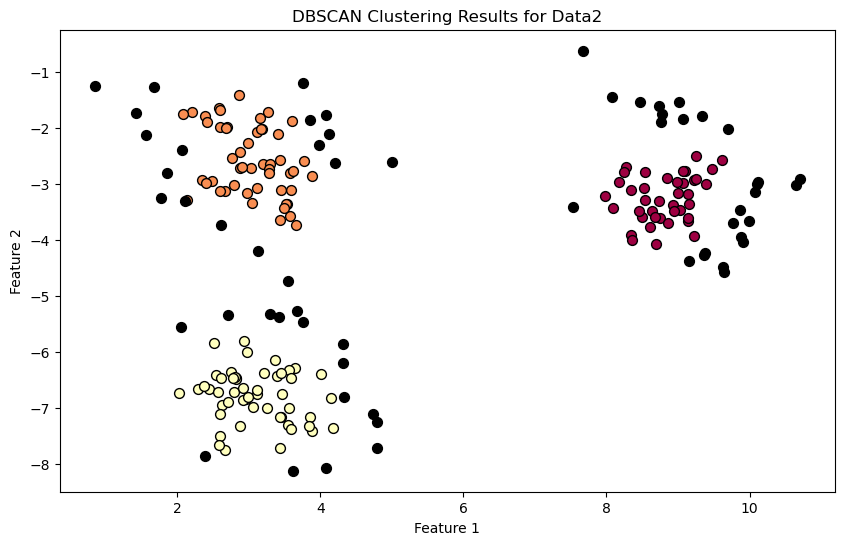

In [33]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(cluster_labels)

# plotting each cluster
for label in unique_labels:
    if label == -1:
        col = 'k'
        markersize = 6
    else:
        col = plt.cm.Spectral(float(label) / len(unique_labels))
        markersize = 12

    # Plot data points that are apart of the cluster (label)
    plt.scatter(data2[cluster_labels == label, 0], data2[cluster_labels == label, 1], c=[col], edgecolor='k', s=50)

plt.title('DBSCAN Clustering Results for Data2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### Third Dataset Run

In [34]:
# Run the ensemble clustering on data3
dbscan_model, eps, minPts, cluster_labels = ensemble_clustering(data3, max_k=10)

# Filtering out noise points 
filtered_labels = cluster_labels[cluster_labels != -1]
filtered_data = data3[cluster_labels != -1]  

# Calculate silhouette score
if len(set(filtered_labels)) > 1 and len(set(filtered_labels)) < len(filtered_data):
    score = silhouette_score(filtered_data, filtered_labels)
    print("Silhouette Score: ", score)
else:
    print("Silhouette score cannot be calculated for a single cluster or if all points are noise.")

# Print DBSCAN estimated parameters and number of clusters
print(f"Estimated eps: {eps}")
print(f"Estimated minPts: {minPts}")
print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")


Silhouette Score:  0.27408217575550375
Estimated eps: 0.24575985602242245
Estimated minPts: 9
Number of clusters found: 3


#### Visualization (Dataset 3)

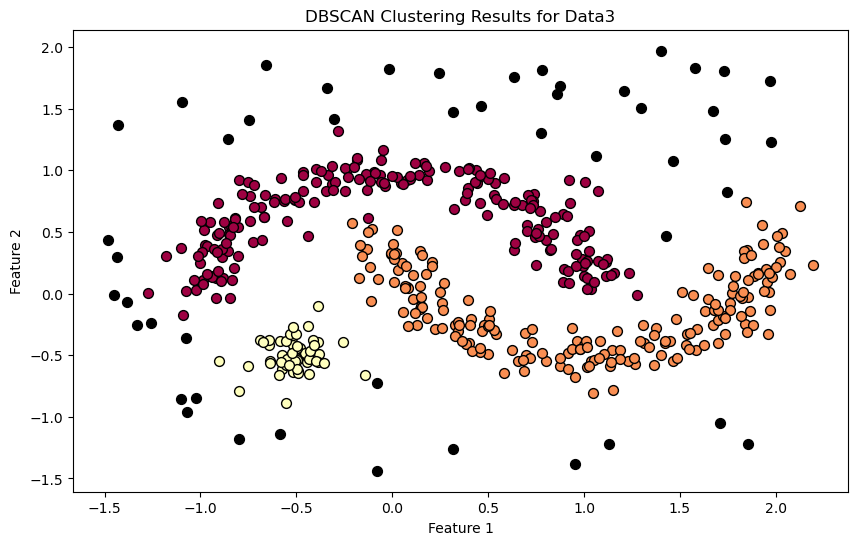

In [35]:
# Visualizing the clustering for data3
plt.figure(figsize=(10, 6))
unique_labels = set(cluster_labels)

# plotting each cluster
for label in unique_labels:
    if label == -1:
        col = 'k'
        markersize = 6
    else:
        col = plt.cm.Spectral(float(label) / len(unique_labels))
        markersize = 12

    # Plotting data points that are part of the cluster (label)
    plt.scatter(data3[cluster_labels == label, 0], data3[cluster_labels == label, 1], c=[col], edgecolor='k', s=50)

plt.title('DBSCAN Clustering Results for Data3')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### Fourth Dataset Run (Real World)

In [38]:
# Run the ensemble clustering on wine_data
dbscan_model, eps, minPts, cluster_labels = ensemble_clustering(wine_data, max_k=15)

# Filter out noise points 
filtered_labels = cluster_labels[cluster_labels != -1]
filtered_data = wine_data[cluster_labels != -1]

# Calculate silhouette score
if len(set(filtered_labels)) > 1 and len(set(filtered_labels)) < len(filtered_data):
    score = silhouette_score(filtered_data, filtered_labels)
    print("Silhouette Score: ", score)
else:
    print("Silhouette score cannot be calculated for a single cluster or if all points are noise.")

# Print DBSCAN parameters and number of clusters
print(f"Estimated eps: {eps}")
print(f"Estimated minPts: {minPts}")
print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")



Silhouette Score:  0.4219099022792628
Estimated eps: 30.091969028297235
Estimated minPts: 13
Number of clusters found: 3


#### Visualization (Applying PCA)

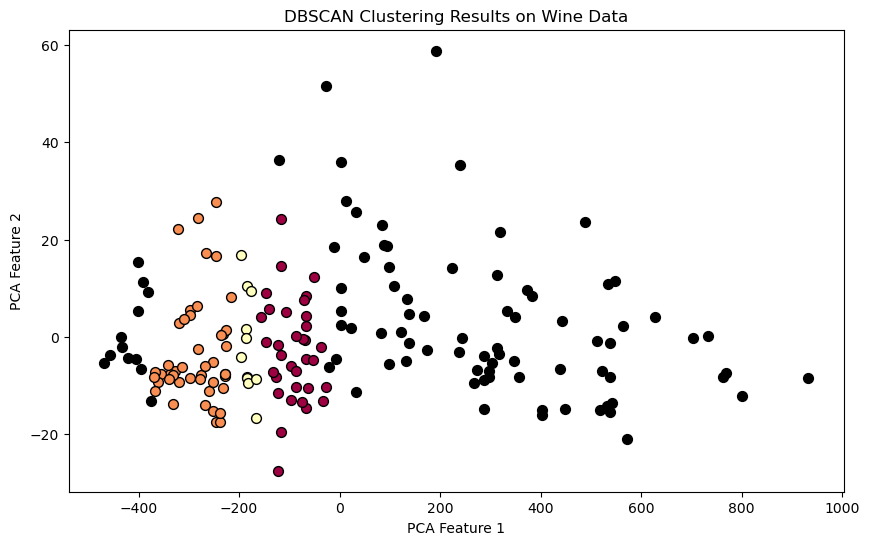

In [37]:
# Applying PCA 
pca = PCA(n_components=2)
wine_data_reduced = pca.fit_transform(wine_data)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(cluster_labels)

for label in unique_labels:
    if label == -1:
        col = 'k'
        markersize = 6
    else:
        col = plt.cm.Spectral(float(label) / len(unique_labels))
        markersize = 12

    # Select data points that belong to the current cluster (or noise)
    cluster_data = wine_data_reduced[cluster_labels == label]

    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=[col], edgecolor='k', s= 50)

plt.title('DBSCAN Clustering Results on Wine Data')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()